# Data Preparation

## Load libraries

In [1]:
#! pip install gensim

In [2]:
#!pip install pyLDAvis

In [3]:
import pandas as pd
import numpy as np 
import re
import spacy
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from collections import Counter
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk import word_tokenize

In [4]:
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

from pprint import pprint

import spacy

import pickle
import re 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

## Load the data

In [5]:
df = pd.read_csv('DisneylandReviews.csv', encoding='latin-1')

In [6]:
len(df)

42656

In [7]:
df.head(10)

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong
5,670591897,3,2019-4,Singapore,"Have been to Disney World, Disneyland Anaheim ...",Disneyland_HongKong
6,670585330,5,2019-4,India,Great place! Your day will go by and you won't...,Disneyland_HongKong
7,670574142,3,2019-3,Malaysia,Think of it as an intro to Disney magic for th...,Disneyland_HongKong
8,670571027,2,2019-4,Australia,"Feel so let down with this place,the Disneylan...",Disneyland_HongKong
9,670570869,5,2019-3,India,I can go on talking about Disneyland. Whatever...,Disneyland_HongKong


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


## Clean the data

In [9]:
reviews = df['Review_Text'].to_list()


In [10]:
# Regex cleaning

for i in range(len(reviews)):
    reviews[i]=re.sub(r'(https?://\S+)','', reviews[i]) # Remove all the urls 
    reviews[i]=re.sub(r'\W',' ', reviews[i]) # Remove all special characters 
    reviews[i]=re.sub('[,\\.!?]', '', reviews[i]) # Remove puntucations 
    reviews[i]=reviews[i].lower() # lowercase    
    
    # Reduce variations for frequently used words 
    reviews[i]=re.sub(r'\b(disney(?:\s|)land|disney)\b','disneyland', reviews[i], flags=re.IGNORECASE)
    reviews[i]=re.sub(r'\b(Child|Children|kids?|sons?|boys?|girls?)\b', 'children', reviews[i], flags=re.IGNORECASE)


In [11]:
# Get the stopwords 
nltk_stopwords = set(stopwords.words('English'))

# Remove stopwords
cleaned= []
for r in reviews:
    words = word_tokenize(r)
    new_words = []
    for word in words:
        if word.lower() in nltk_stopwords:
            continue
        new_words.append(word)
    cleaned_review = " ".join(new_words)
    cleaned.append(cleaned_review)

In [12]:
# Lemmitzation 
lemmatizer = WordNetLemmatizer()
lemm = []

for r in cleaned:
    words = word_tokenize(r)
    new_words = []
    for word in words:
        new_words.append(lemmatizer.lemmatize(word))
    cleaned_review = " ".join(new_words)
    lemm.append(cleaned_review)

In [13]:
# Append the finalized reviews to dataset 
df['Review_Text'] = lemm 

In [14]:
df

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,ever disneyland anywhere find disneyland hong ...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,since last time visit hk disneyland yet time s...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,thanks god hot humid visiting park otherwise w...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,hk disneyland great compact park unfortunately...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,location city took around 1 hour kowlon child ...,Disneyland_HongKong
...,...,...,...,...,...,...
42651,1765031,5,missing,United Kingdom,went disneyland paris july 03 thought brillian...,Disneyland_Paris
42652,1659553,5,missing,Canada,2 adult 1 child 11 visited disneyland paris be...,Disneyland_Paris
42653,1645894,5,missing,South Africa,eleven year old daughter went visit child lond...,Disneyland_Paris
42654,1618637,4,missing,United States,hotel part disneyland paris complex wonderful ...,Disneyland_Paris


# Topic Modeling 

In [15]:
#Positive review
df_positive=df.loc[(df['Rating']>3)]

In [16]:
#Negative and Neutral review 
df_negative = df.loc[(df['Rating']<=3)]

## HK Branch 

### Positive Reviews

In [17]:
# Subset the HK data 
HK=df_positive.loc[(df_positive['Branch']=="Disneyland_HongKong")]

# Reduce variations of HongKong 
HK['Review_Text'] = HK['Review_Text'].str.replace(r'\b(hong(?:\s|)kong|hkg|hk)\b','hongkong')


<ipython-input-17-af1b86c2dd30>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  HK['Review_Text'] = HK['Review_Text'].str.replace(r'\b(hong(?:\s|)kong|hkg|hk)\b','hongkong')
<ipython-input-17-af1b86c2dd30>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HK['Review_Text'] = HK['Review_Text'].str.replace(r'\b(hong(?:\s|)kong|hkg|hk)\b','hongkong')


In [18]:
HK.head(5)

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,ever disneyland anywhere find disneyland hongk...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,since last time visit hongkong disneyland yet ...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,thanks god hot humid visiting park otherwise w...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,hongkong disneyland great compact park unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,location city took around 1 hour kowlon child ...,Disneyland_HongKong


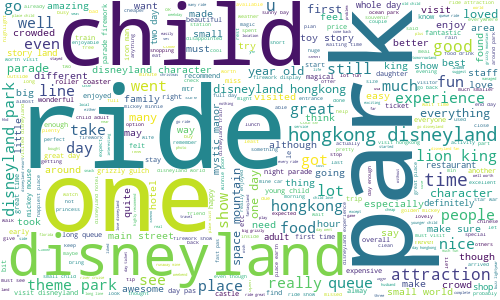

In [19]:
# Import WordCloud
from wordcloud import WordCloud

HK_text = " ".join(txt for txt in HK.Review_Text)
wc = WordCloud(background_color="white", width=500, height=300,
               max_words=1000, contour_width=3, contour_color='steelblue')
wc.generate(HK_text)
wc.to_image()



#### Topic modeling - LDA

In [20]:
hk_review = HK['Review_Text'].to_list()

In [21]:
#Let’s tokenize each sentence into a list of words, 
#removing punctuations and unnecessary characters altogether.
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(hk_review))

print(data_words[:1])

[['ever', 'disneyland', 'anywhere', 'find', 'disneyland', 'hongkong', 'similar', 'layout', 'walk', 'main', 'street', 'familiar', 'feel', 'one', 'ride', 'small', 'world', 'absolutely', 'fabulous', 'worth', 'day', 'visited', 'fairly', 'hot', 'relatively', 'busy', 'queue', 'moved', 'fairly', 'well']]


In [22]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)]]


In [23]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('absolutely', 1),
  ('anywhere', 1),
  ('busy', 1),
  ('day', 1),
  ('disneyland', 2),
  ('ever', 1),
  ('fabulous', 1),
  ('fairly', 2),
  ('familiar', 1),
  ('feel', 1),
  ('find', 1),
  ('hongkong', 1),
  ('hot', 1),
  ('layout', 1),
  ('main', 1),
  ('moved', 1),
  ('one', 1),
  ('queue', 1),
  ('relatively', 1),
  ('ride', 1),
  ('similar', 1),
  ('small', 1),
  ('street', 1),
  ('visited', 1),
  ('walk', 1),
  ('well', 1),
  ('world', 1),
  ('worth', 1)]]

In [24]:
# Build LDA model
# We choose the number of topic to be 3. Too many topics may not give us useful information
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [25]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.045*"disneyland" + 0.023*"day" + 0.021*"child" + 0.021*"ride" + '
  '0.017*"hongkong" + 0.017*"park" + 0.016*"time" + 0.011*"one" + '
  '0.009*"great" + 0.009*"place"'),
 (1,
  '0.033*"park" + 0.015*"ride" + 0.013*"line" + 0.013*"mountain" + '
  '0.012*"space" + 0.010*"land" + 0.010*"minute" + 0.008*"chinese" + '
  '0.008*"main" + 0.007*"toy"'),
 (2,
  '0.065*"mickey" + 0.042*"show" + 0.027*"king" + 0.026*"lion" + '
  '0.021*"golden" + 0.016*"character" + 0.012*"mouse" + 0.012*"fantasy" + '
  '0.011*"minnie" + 0.010*"photo"')]


In [26]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -7.065276812291336

Coherence Score:  0.4005200905426176


In [27]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/Users/mirandazhou/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.223602  0.184972       1        1  72.137313
1     -0.097954 -0.240374       2        1  20.539041
2      0.321555  0.055402       3        1   7.323646, topic_info=          Term         Freq        Total Category  logprob  loglift
238       show  3256.000000  3256.000000  Default  30.0000  30.0000
336     mickey  1885.000000  1885.000000  Default  29.0000  29.0000
82        park  7582.000000  7582.000000  Default  28.0000  28.0000
306  character  1650.000000  1650.000000  Default  27.0000  27.0000
3          day  6531.000000  6531.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
346  adventure   157.193795   328.265041   Topic3  -5.2182   1.8777
348       boat   110.721859   163.362071   Topic3  -5.5687   2.2251
117     castle   118.093017   436.240488   Topic3  -5.5042   1.3073
144     parade   112.467234  2204.116028   Topic3  -5.5530  -0.3614
224       miss   110.294512   548.674033   Topic3  -5.5725   1.0097

[180 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
404       1  0.999742      adult
346       1  0.018278  adventure
346       2  0.505689  adventure
346       3  0.478272  adventure
29        1  0.880119       also
...     ...       ...        ...
157       1  0.908141      would
157       2  0.091596      would
402       1  0.997634       year
402       2  0.002636       year
289       1  0.998757      young

[210 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

### Negative Reviews

In [28]:
# Negative
# Subset the HK data 
HK=df_negative.loc[(df_negative['Branch']=="Disneyland_HongKong")]

# Reduce variations HongKong 
HK['Review_Text'] = HK['Review_Text'].str.replace(r'\b(hong(?:\s|)kong|hkg|hk)\b','hongkong')

<ipython-input-28-bc88d43f229a>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  HK['Review_Text'] = HK['Review_Text'].str.replace(r'\b(hong(?:\s|)kong|hkg|hk)\b','hongkong')
<ipython-input-28-bc88d43f229a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HK['Review_Text'] = HK['Review_Text'].str.replace(r'\b(hong(?:\s|)kong|hkg|hk)\b','hongkong')


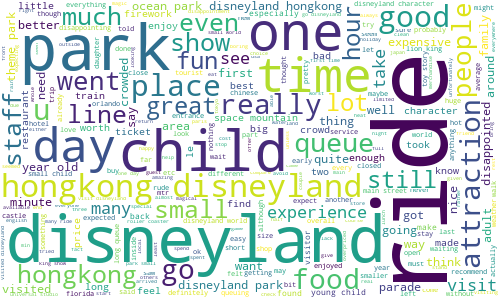

In [29]:
# Import WordCloud
from wordcloud import WordCloud


HK_text = " ".join(txt for txt in HK.Review_Text)
wc = WordCloud(background_color="white", width=500, height=300,
               max_words=1000, contour_width=3, contour_color='steelblue')
wc.generate(HK_text)
wc.to_image()



#### Topic Modeling - LDA

In [30]:
hk_review = HK['Review_Text'].to_list()

In [31]:
#Let’s tokenize each sentence into a list of words, 
#removing punctuations and unnecessary characters altogether.
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(hk_review))

print(data_words[:1])

[['disneyland', 'world', 'disneyland', 'anaheim', 'tokyo', 'disneyland', 'feel', 'disneyland', 'hongkong', 'really', 'small', 'called', 'disneyland', 'way', 'ride', 'attraction', 'souvenir', 'food', 'even', 'entrance', 'ticket', 'slightly', 'expensive', 'disneyland', 'well', 'basically', 'park', 'good', 'small', 'child', 'people', 'never', 'disneyland', 'food', 'choice', 'acceptable', 'mostly', 'fast', 'food', 'expensive', 'bottled', 'water', 'however', 'expensive', 'water', 'fountain', 'around', 'refill', 'water', 'bottle', 'parade', 'pretty', 'good', 'crowded', 'problem', 'problem', 'people', 'rude', 'pushing', 'shoving', 'cutting', 'line', 'ride', 'gift', 'shop', 'food', 'stand', 'much', 'take', 'forget', 'trying', 'see', 'one', 'show', 'free', 'seat', 'see', 'disneyland', 'let', 'happen', 'far', 'worst', 'managed', 'disneyland', 'property']]


In [32]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 9), (13, 1), (14, 1), (15, 3), (16, 1), (17, 1), (18, 1), (19, 4), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 2), (38, 1), (39, 2), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 2), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 3), (60, 1), (61, 1), (62, 1), (63, 1)]]


In [33]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('acceptable', 1),
  ('anaheim', 1),
  ('around', 1),
  ('attraction', 1),
  ('basically', 1),
  ('bottle', 1),
  ('bottled', 1),
  ('called', 1),
  ('child', 1),
  ('choice', 1),
  ('crowded', 1),
  ('cutting', 1),
  ('disneyland', 9),
  ('entrance', 1),
  ('even', 1),
  ('expensive', 3),
  ('far', 1),
  ('fast', 1),
  ('feel', 1),
  ('food', 4),
  ('forget', 1),
  ('fountain', 1),
  ('free', 1),
  ('gift', 1),
  ('good', 2),
  ('happen', 1),
  ('hongkong', 1),
  ('however', 1),
  ('let', 1),
  ('line', 1),
  ('managed', 1),
  ('mostly', 1),
  ('much', 1),
  ('never', 1),
  ('one', 1),
  ('parade', 1),
  ('park', 1),
  ('people', 2),
  ('pretty', 1),
  ('problem', 2),
  ('property', 1),
  ('pushing', 1),
  ('really', 1),
  ('refill', 1),
  ('ride', 2),
  ('rude', 1),
  ('seat', 1),
  ('see', 2),
  ('shop', 1),
  ('shoving', 1),
  ('show', 1),
  ('slightly', 1),
  ('small', 2),
  ('souvenir', 1),
  ('stand', 1),
  ('take', 1),
  ('ticket', 1),
  ('tokyo', 1),
  ('trying', 1),
  ('wat

In [34]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [35]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.041*"disneyland" + 0.026*"park" + 0.022*"ride" + 0.017*"child" + '
  '0.015*"hongkong" + 0.011*"day" + 0.011*"time" + 0.010*"one" + 0.009*"small" '
  '+ 0.008*"go"'),
 (1,
  '0.014*"jungle" + 0.013*"cruise" + 0.010*"boat" + 0.009*"hope" + '
  '0.008*"river" + 0.006*"watching" + 0.005*"fantasyland" + 0.005*"market" + '
  '0.005*"treehouse" + 0.005*"tree"'),
 (2,
  '0.017*"staff" + 0.011*"people" + 0.011*"tourist" + 0.009*"rude" + '
  '0.009*"mainland" + 0.009*"china" + 0.008*"service" + 0.007*"pushing" + '
  '0.007*"english" + 0.007*"queue"')]


In [36]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.142331173739573

Coherence Score:  0.3388568968413291


In [37]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/Users/mirandazhou/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.290314 -0.004961       1        1  87.448394
2     -0.151519 -0.167304       2        1   9.828226
1     -0.138795  0.172265       3        1   2.723380, topic_info=            Term         Freq        Total Category  logprob  loglift
37        people   443.000000   443.000000  Default  30.0000  30.0000
92         staff   257.000000   257.000000  Default  29.0000  29.0000
12    disneyland  3429.000000  3429.000000  Default  28.0000  28.0000
470        queue   590.000000   590.000000  Default  27.0000  27.0000
36          park  2137.000000  2137.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
2345        snow     9.913571    16.665961   Topic3  -5.5608   3.0838
1122     thunder    10.553695    27.709819   Topic3  -5.4983   2.6380
2814       green     7.352698    10.644644   Topic3  -5.8597   3.2333
1402     mansion     8.909229    29.797482   Topic3  -5.6677   2.3960
580      haunted     7.898346    63.003838   Topic3  -5.7881   1.5268

[156 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2087      3  0.978803  angeles
797       2  0.082815   animal
797       3  0.910963   animal
2         1  0.997617   around
829       2  0.983867    asked
...     ...       ...      ...
62        1  0.998316    world
63        1  0.603263    worst
63        2  0.402175    worst
146       1  0.998963    would
243       1  0.998919     year

[174 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

## Paris Branch

### Positive Reviews

In [38]:
# Subset the Paris data 
PA=df_positive.loc[(df_positive['Branch']=="Disneyland_Paris")]


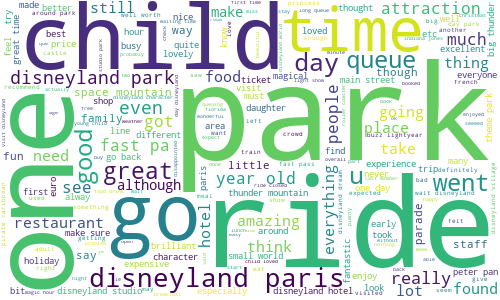

In [39]:
# Import WordCloud
from wordcloud import WordCloud


PA_text = " ".join(txt for txt in PA.Review_Text)
wc = WordCloud(background_color="white", width=500, height=300,
               max_words=1000, contour_width=3, contour_color='steelblue')
wc.generate(PA_text)
wc.to_image()



#### Topic modeling - LDA

In [40]:
pa_review = PA['Review_Text'].to_list()

In [41]:
#Let’s tokenize each sentence into a list of words, 
#removing punctuations and unnecessary characters altogether.
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(pa_review))

print(data_words[:1])



# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])


# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


[['disneyland', 'hongkong', 'tokyo', 'far', 'one', 'best', 'looking', 'forward', 'visit', 'biggest', 'one', 'orlando', 'day', 'enough', 'recommended', 'stay', 'disneyland', 'hotel', 'resort', 'enjoy', 'fast', 'track', 'save', 'huge', 'amount', 'time', 'staying', 'plan', 'strategize', 'visit', 'getting', 'fast', 'track', 'pass', 'kiosk', 'nearby', 'attraction', 'come', 'back', 'time', 'ride', 'projection', 'firework', 'show', 'world']]
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 2), (35, 1), (36, 2), (37, 2), (38, 1)]]


In [42]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.033*"disneyland" + 0.026*"park" + 0.023*"ride" + 0.019*"child" + '
  '0.018*"time" + 0.013*"day" + 0.011*"great" + 0.010*"go" + 0.009*"paris" + '
  '0.009*"good"'),
 (1,
  '0.025*"get" + 0.018*"park" + 0.016*"day" + 0.016*"hotel" + 0.013*"take" + '
  '0.012*"queue" + 0.011*"ticket" + 0.011*"one" + 0.010*"fast" + 0.010*"euro"'),
 (2,
  '0.021*"hotel" + 0.014*"breakfast" + 0.014*"character" + 0.013*"meal" + '
  '0.011*"mickey" + 0.011*"room" + 0.010*"cafe" + 0.008*"got" + 0.008*"stayed" '
  '+ 0.007*"princess"')]


In [43]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -7.15805152032805

Coherence Score:  0.37840268064500543


In [44]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/Users/mirandazhou/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.199538  0.153560       1        1  63.540161
1     -0.074766 -0.208449       2        1  25.660870
2      0.274304  0.054889       3        1  10.798969, topic_info=          Term         Freq        Total Category  logprob  loglift
16       hotel  4568.000000  4568.000000  Default  30.0000  30.0000
57         get  6213.000000  6213.000000  Default  29.0000  29.0000
399  character  2729.000000  2729.000000  Default  28.0000  28.0000
202       take  2580.000000  2580.000000  Default  27.0000  27.0000
219     ticket  2050.000000  2050.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
527        eat   321.450331  1061.976610   Topic3  -5.4993   1.0307
123      child   469.754925  9379.078780   Topic3  -5.1199  -0.7683
847       main   319.969224  1635.776672   Topic3  -5.5039   0.5941
244     review   302.719510  1035.039347   Topic3  -5.5593   0.9963
757      drink   298.983015  1572.478879   Topic3  -5.5717   0.5657

[206 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
39        2  0.997598     access
1783      2  0.998789    advance
1254      2  0.998107  advantage
328       1  0.999571        age
2757      2  0.999620    airport
...     ...       ...        ...
92        1  0.883643      would
92        2  0.106545      would
92        3  0.009748      would
112       1  0.999616       year
112       3  0.000290       year

[271 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

### Negative Reviews

In [45]:
# Subset the Paris data 
PA=df_negative.loc[(df_negative['Branch']=="Disneyland_Paris")]


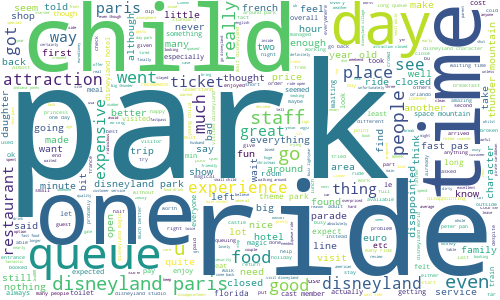

In [46]:
# Import WordCloud
from wordcloud import WordCloud


PA_text = " ".join(txt for txt in PA.Review_Text)
wc = WordCloud(background_color="white", width=500, height=300,
               max_words=1000, contour_width=3, contour_color='steelblue')
wc.generate(PA_text)
wc.to_image()


#### Topic Modeling - LDA

In [47]:
pa_review = PA['Review_Text'].to_list()

In [48]:
#Let’s tokenize each sentence into a list of words, 
#removing punctuations and unnecessary characters altogether.
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(pa_review))

print(data_words[:1])



# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])


# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


[['booked', 'ticket', 'line', 'disneyland', 'something', 'recommend', 'line', 'already', 'long', 'got', 'booking', 'ticket', 'advance', 'help', 'advised', 'buy', 'fast', 'pass', 'decided', 'clear', 'website', 'also', 'counted', 'entrance', 'ticket', 'meaning', 'total', 'price', 'euro', 'extra', 'euro', 'depending', 'age', 'child', 'even', 'would', 'line', 'long', 'well', 'also', 'kind', 'system', 'people', 'much', 'spend', 'held', 'back', 'people', 'money', 'obviously', 'skip', 'line', 'absolutely', 'ridiculous', 'getting', 'something', 'eat', 'horrible', 'line', 'everywhere', 'eat', 'someting', 'right', 'get', 'started', 'staff', 'trying', 'figure', 'amount', 'icecream', 'small', 'casio', 'computer', 'able', 'rude', 'staff', 'lady', 'friendly', 'honest', 'disappointing', 'long', 'waiting', 'line', 'able', 'sit', 'somewhere', 'like', 'human', 'bad', 'service', 'child', 'disappointed', 'wanted', 'leave', 'even', 'heard', 'people', 'saying', 'never', 'absolutely', 'worth', 'money']]
[[(0

In [49]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.026*"hotel" + 0.024*"room" + 0.013*"meal" + 0.012*"breakfast" + '
  '0.009*"coffee" + 0.008*"euro" + 0.007*"buffet" + 0.007*"sequoia" + '
  '0.007*"fe" + 0.006*"cheese"'),
 (1,
  '0.020*"child" + 0.011*"get" + 0.011*"hotel" + 0.010*"staff" + 0.007*"could" '
  '+ 0.007*"people" + 0.007*"character" + 0.007*"told" + 0.006*"daughter" + '
  '0.006*"bus"'),
 (2,
  '0.029*"disneyland" + 0.023*"park" + 0.019*"ride" + 0.013*"time" + '
  '0.011*"day" + 0.010*"child" + 0.009*"queue" + 0.009*"one" + 0.009*"go" + '
  '0.008*"paris"')]


In [50]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -7.364421413768067

Coherence Score:  0.36878317148253376


In [51]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/Users/mirandazhou/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.233508  0.123346       1        1  81.620613
1     -0.051686 -0.189918       2        1  16.163334
0      0.285193  0.066573       3        1   2.216054, topic_info=            Term         Freq        Total Category  logprob  loglift
362        hotel  1847.000000  1847.000000  Default  30.0000  30.0000
14         child  4623.000000  4623.000000  Default  29.0000  29.0000
25          euro  1353.000000  1353.000000  Default  28.0000  28.0000
666         room   567.000000   567.000000  Default  27.0000  27.0000
22    disneyland  9414.000000  9414.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1317         tea    41.028398   138.845325   Topic3  -5.3723   2.5903
811      village    54.096347   454.854473   Topic3  -5.0958   1.6802
25          euro    68.637537  1353.557763   Topic3  -4.8577   0.8278
2518         bay    36.700817   107.818604   Topic3  -5.4838   2.7318
406        drink    31.102239   583.968069   Topic3  -5.6493   0.8769

[214 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
6         1  0.997936    also
6         2  0.001541    also
162       1  0.912001  around
162       2  0.088116  around
709       2  0.995285     ask
...     ...       ...     ...
80        2  0.149309   would
1991      2  0.989988   write
301       1  0.930336    year
301       2  0.069971    year
688       2  0.986652      yr

[284 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

## CA Branch 

### Positive Reviews 

In [52]:
# Subset the Paris data 
CA=df_positive.loc[(df_positive['Branch']=="Disneyland_California")]

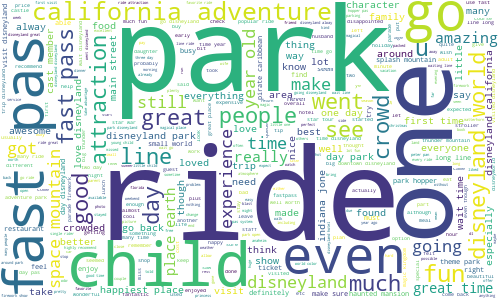

In [53]:
# Import WordCloud
from wordcloud import WordCloud


CA_text = " ".join(txt for txt in CA.Review_Text)
wc = WordCloud(background_color="white", width=500, height=300,
               max_words=1000, contour_width=3, contour_color='steelblue')
wc.generate(CA_text)
wc.to_image()



#### Topic modeling - LDA

In [54]:
ca_review = CA['Review_Text'].to_list()

In [55]:
#Let’s tokenize each sentence into a list of words, 
#removing punctuations and unnecessary characters altogether.
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(ca_review))

print(data_words[:1])



# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])


# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


[['place', 'always', 'forever', 'special', 'feeling', 'get', 'entering', 'park', 'seeing', 'character', 'different', 'attraction', 'priceless', 'definitely', 'dream', 'trip', 'age', 'especially', 'young', 'child', 'spend', 'money', 'go', 'disneyland', 'regret']]
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1)]]


In [56]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.052*"disneyland" + 0.022*"time" + 0.021*"child" + 0.021*"park" + '
  '0.016*"ride" + 0.015*"great" + 0.012*"go" + 0.011*"year" + 0.011*"day" + '
  '0.011*"place"'),
 (1,
  '0.028*"mountain" + 0.018*"space" + 0.017*"ride" + 0.015*"pirate" + '
  '0.013*"jones" + 0.012*"world" + 0.012*"indiana" + 0.010*"haunted" + '
  '0.009*"mansion" + 0.009*"tour"'),
 (2,
  '0.026*"ride" + 0.025*"get" + 0.023*"day" + 0.020*"park" + 0.018*"line" + '
  '0.013*"time" + 0.012*"pas" + 0.011*"fast" + 0.011*"one" + 0.009*"wait"')]


In [57]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)




Perplexity:  -7.04724081039155

Coherence Score:  0.46521810412549064


In [58]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/Users/mirandazhou/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.190835  0.184638       1        1  55.382869
2     -0.136823 -0.206108       2        1  34.090125
1      0.327658  0.021470       3        1  10.527006, topic_info=           Term          Freq         Total Category  logprob  loglift
7    disneyland  25240.000000  25240.000000  Default  30.0000  30.0000
13          get   7971.000000   7971.000000  Default  29.0000  29.0000
4         child  10240.000000  10240.000000  Default  28.0000  28.0000
112    mountain   2631.000000   2631.000000  Default  27.0000  27.0000
350        line   6537.000000   6537.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
450         big    542.689026   1519.683247   Topic3  -5.1367   1.2215
270        area    472.400017   1312.465519   Topic3  -5.2754   1.2294
84         also    533.549520   3562.250214   Topic3  -5.1537   0.3526
273  california    522.055997   4853.674813   Topic3  -5.1754   0.0215
265   adventure    476.857416   3476.607210   Topic3  -5.2660   0.2646

[185 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
265       1  0.451302  adventure
265       2  0.411608  adventure
265       3  0.137203  adventure
0         1  0.999671        age
84        1  0.252930       also
...     ...       ...        ...
137       1  0.621918      world
137       3  0.377958      world
139       1  0.793960      would
139       2  0.205944      would
140       1  0.999826       year

[214 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

### Negative Reviews

In [59]:
# Subset the Paris data 
CA=df_negative.loc[(df_negative['Branch']=="Disneyland_California")]

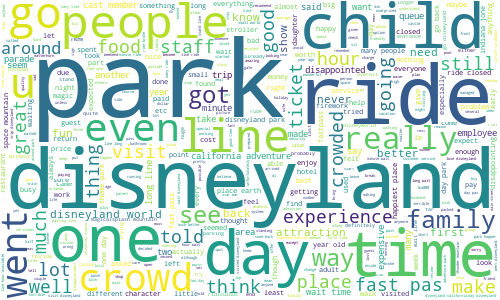

In [60]:
# Import WordCloud
from wordcloud import WordCloud


CA_text = " ".join(txt for txt in CA.Review_Text)
wc = WordCloud(background_color="white", width=500, height=300,
               max_words=1000, contour_width=3, contour_color='steelblue')
wc.generate(CA_text)
wc.to_image()


#### Topic Modeling - LDA

In [61]:
ca_review = CA['Review_Text'].to_list()

In [62]:
#Let’s tokenize each sentence into a list of words, 
#removing punctuations and unnecessary characters altogether.
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(ca_review))

print(data_words[:1])



# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])


# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


[['took', 'child', 'park', 'weekend', 'fri', 'sun', 'busy', 'place', 'child', 'enjoyed', 'sad', 'could', 'try', 'lot', 'attraction', 'wait', 'time', 'huge', 'ranging', 'minute', 'lot', 'time', 'waste', 'waiting', 'line', 'attraction', 'fastpass', 'system', 'park', 'ripoff', 'one', 'attraction', 'added', 'plan', 'point', 'complete', 'attraction', 'add', 'one']]
[[(0, 1), (1, 1), (2, 4), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 2), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1)]]


In [63]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.047*"ride" + 0.021*"day" + 0.014*"park" + 0.014*"time" + '
  '0.013*"disneyland" + 0.011*"line" + 0.010*"get" + 0.010*"wait" + '
  '0.010*"minute" + 0.010*"california"'),
 (1,
  '0.018*"asked" + 0.017*"told" + 0.016*"member" + 0.015*"cast" + 0.011*"said" '
  '+ 0.008*"guest" + 0.008*"ticket" + 0.007*"relation" + 0.006*"service" + '
  '0.006*"employee"'),
 (2,
  '0.039*"disneyland" + 0.023*"park" + 0.015*"people" + 0.012*"time" + '
  '0.012*"line" + 0.010*"child" + 0.009*"one" + 0.008*"get" + 0.008*"would" + '
  '0.008*"place"')]


In [64]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)




Perplexity:  -7.321741686732526

Coherence Score:  0.33758746828976666


In [65]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/Users/mirandazhou/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.164310 -0.144990       1        1  46.972354
2     -0.140617  0.152701       2        1  46.895602
1      0.304926 -0.007710       3        1   6.132044, topic_info=            Term         Freq        Total Category  logprob  loglift
203         ride  5191.000000  5191.000000  Default  30.0000  30.0000
84    disneyland  5398.000000  5398.000000  Default  29.0000  29.0000
237         told   500.000000   500.000000  Default  28.0000  28.0000
79           day  2582.000000  2582.000000  Default  27.0000  27.0000
930       member   306.000000   306.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1186    security    38.229006   145.179495   Topic3  -5.8781   1.4573
537          ask    34.344708    63.785696   Topic3  -5.9852   2.1726
558      husband    36.574139   128.372843   Topic3  -5.9223   1.5360
1161      behind    35.280412    97.357836   Topic3  -5.9583   1.7766
6          could    38.449949   860.997381   Topic3  -5.8723  -0.3171

[221 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
33        1  0.979368  adventure
33        2  0.019757  adventure
531       1  0.879255       also
531       2  0.119806       also
38        2  0.998049     amount
...     ...       ...        ...
528       2  0.994758      worst
254       1  0.404995      would
254       2  0.594923      would
255       1  0.334972       year
255       2  0.665266       year

[297 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

# Rating Predictive Models


In [66]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn import model_selection, naive_bayes
from sklearn.feature_extraction.text import TfidfVectorizer
import random

In [67]:
for i in range(len(df)):
    if df.loc[i,'Rating'] > 3:
        df.loc[i,'Label'] = 1
    else:
        df.loc[i,'Label'] = 0

In [68]:
df['Label'].value_counts()

1.0    33921
0.0     8735
Name: Label, dtype: int64

In [69]:
lemmatizer = WordNetLemmatizer()
df['Cleaned'] = [lemmatizer.lemmatize(row) for row in df['Review_Text']]
df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,Label,Cleaned
0,670772142,4,2019-4,Australia,ever disneyland anywhere find disneyland hong ...,Disneyland_HongKong,1.0,ever disneyland anywhere find disneyland hong ...
1,670682799,4,2019-5,Philippines,since last time visit hk disneyland yet time s...,Disneyland_HongKong,1.0,since last time visit hk disneyland yet time s...
2,670623270,4,2019-4,United Arab Emirates,thanks god hot humid visiting park otherwise w...,Disneyland_HongKong,1.0,thanks god hot humid visiting park otherwise w...
3,670607911,4,2019-4,Australia,hk disneyland great compact park unfortunately...,Disneyland_HongKong,1.0,hk disneyland great compact park unfortunately...
4,670607296,4,2019-4,United Kingdom,location city took around 1 hour kowlon child ...,Disneyland_HongKong,1.0,location city took around 1 hour kowlon child ...


In [70]:
X = df["Cleaned"]
y = df["Label"]

In [71]:
## split train and testing 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2)

In [72]:
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,2), max_features=5000)
tfidf_vect_ngram.fit(X)
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
xtest_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)

## Baseline Model

In [73]:
#Using logistic regression as our baseline model to compare the performance
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(xtrain_tfidf_ngram, y_train)
pred= model.predict(xtest_tfidf_ngram)
acc = accuracy_score(y_test,pred)

print('Accuracy of validation set is :', acc)

Accuracy of validation set is : 0.8860552674575549


## Naive Bayes

In [74]:
#after trying different alphas (from 0.1 - 0.6), 0.1 has the highest validation accuracy
nb = naive_bayes.MultinomialNB(alpha = 0.1)

model = nb.fit(xtrain_tfidf_ngram, y_train)

pred = model.predict(xtest_tfidf_ngram)

acc = accuracy_score(y_test,pred)

print('Accuracy of validation set is :', acc)

Accuracy of validation set is : 0.8670881579882077


In [75]:
score = f1_score(y_test, pred, average='weighted')
print("Weighted F score is ",score)

Weighted F score is  0.8494865733090182


## Random Forest

In [76]:
#Random Forest Classifer
#we tried different n_estimators from 50 - 300, adding 50 each time. 
#n_estimators = 100 has the highest validation accuracy
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100)
classifier.fit(xtrain_tfidf_ngram,y_train)
preds=classifier.predict(xtest_tfidf_ngram)

acc = accuracy_score(y_test,preds)

print('Accuracy of validation set is :', acc)

Accuracy of validation set is : 0.8440008524543582


## XGBoost

In [77]:
## countvectorizer 
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range=(1, 1), 
                             token_pattern='(?u)\\b[a-zA-Z][a-zA-Z]+\\b',max_features = 1000)
X = cv.fit_transform(df['Cleaned'])



In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state= 2)

In [79]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# we tried different n estimators from 200 - 1000, 300 performs the best
model = XGBClassifier(n_estimators = 300)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f%%' % (accuracy * 100.0))
print(f'Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}')

/Users/mirandazhou/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:27:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 86.95%
Confusion Matrix:
[[ 1565  1317]
 [  520 10675]]
